In [ ]:
# !git clone https://github.com/AbdElRahmanElGharib/DistYOLO.git
# !mv /content/DistYOLO/* /content/
# !rm LICENSE README.md
# from google.colab.files import upload
# upload()
# from google.colab.drive import mount
# mount('/content/drive/')
# !pip install -q keras-cv
# !pip install -q kaggle
# !mkdir ~/.kaggle
# !mv kaggle.json ~/.kaggle
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download --unzip -d klemenko/kitti-dataset
# !mkdir ./images ./labels
# !mv /content/data_object_label_2/training/label_2/* ./labels/
# !mv /content/data_object_image_2/training/image_2/* ./images/
# !rm -r /content/data_object_image_3/ /content/data_object_calib/ /content/data_object_image_2/ /content/data_object_label_2/ /content/DistYOLO/ /content/sample_data/

In [1]:
import os
import cv2
import tqdm
import json
import pickle
import numpy as np
from math import ceil
import tensorflow as tf
from mobile_yolo_v5 import MobileYOLOv5
from keras_cv import visualization, bounding_box
from augment import RandomFlip, ChannelShuffle, RandomHue, RandomSaturation, RandomBrightness


Using TensorFlow backend


In [2]:
BOUNDING_BOX_FORMAT = 'xyxy'
SPLIT_RATIO = 0.1
EPOCH = 5
BATCH_SIZE = 64
LEARNING_RATE = 5e-3
WEIGHT_DECAY = 7e-4
DECAY_EPOCHS = 5
GLOBAL_CLIPNORM = 10.0
IMAGE_SIZE = 224
MASK_SIZE = 84

In [ ]:
path_labels = '/content/labels/'
path_images = '/content/images/'

label_files = sorted(
    [
        os.path.join(path_labels, file_name)
        for file_name in os.listdir(path_labels)
        if file_name.endswith(".txt")
    ]
)

image_files = sorted(
    [
        os.path.join(path_images, file_name)
        for file_name in os.listdir(path_images)
        if file_name.endswith(".png")
    ]
)

In [ ]:
def parse_annotation(label_file, image_file):

    detections = list(map(str.split, map(lambda x: x[:-1], open(label_file).readlines())))

    boxes = []
    distances = []

    for detection in detections:
        if detection[0] == 'DontCare':
            break

        box = list(map(float, detection[4:8]))

        _shape = cv2.imread(image_file).shape

        box  = (np.array(box)*np.array([IMAGE_SIZE/_shape[1],IMAGE_SIZE/_shape[0],IMAGE_SIZE/_shape[1],IMAGE_SIZE/_shape[0]])).tolist()

        dist = np.sqrt(np.sum(np.square(np.array(list(map(float, detection[11:14])))))).tolist()

        boxes.append(box)
        distances.append(dist)

    return boxes, distances


kitti_images  = []
kitti_boxes   = []
kitti_dists   = []

kitti_classes = []
kitti_masks   = []
kitti_modes   = []

for image_file, label_file in tqdm.tqdm(zip(image_files, label_files)):
    box, dist = parse_annotation(label_file, image_file)
    kitti_images.append(image_file)
    kitti_boxes.append(box)
    kitti_dists.append(dist)

    kitti_classes.append(-1)
    kitti_masks.append(-1)
    kitti_modes.append(1)

In [ ]:
culane_images_path = ''
culane_masks_path = ''

tusimple_images_path = ''
tusimple_masks_path = ''

culane_label_files = sorted(
    [
        os.path.join(culane_masks_path, file_name)
        for file_name in os.walk(culane_masks_path)
        if file_name.endswith(".png")
    ]
)

culane_image_files = sorted(
    [
        os.path.join(culane_images_path, file_name)
        for file_name in os.walk(culane_images_path)
        if file_name.endswith(".jpg")
    ]
)

tusimple_label_files = sorted(
    [
        os.path.join(tusimple_masks_path, file_name)
        for file_name in os.walk(tusimple_masks_path)
        if file_name.endswith(".jpg")
    ]
)

tusimple_image_files = sorted(
    [
        os.path.join(tusimple_images_path, file_name)
        for file_name in os.walk(tusimple_images_path)
        if file_name.endswith(".jpg")
    ]
)

In [ ]:
lane_images  = tusimple_image_files + culane_image_files
lane_masks   = tusimple_label_files + culane_label_files
cnt = len(lane_images)
lane_boxes   = cnt * [-1]
lane_dists   = cnt * [-1]
lane_classes = cnt * [-1]
lane_modes   = cnt * [-1]

In [3]:
train_images_path = r'D:\Model Data\COCO\train2017\train2017'
val_images_path = r'D:\Model Data\COCO\val2017\val2017'

train_annotations_file_path = r'D:\Model Data\COCO\annotations\instances_train2017.json'
val_annotations_file_path = r'D:\Model Data\COCO\annotations\instances_val2017.json'

In [4]:
val_annotations = json.load(open(val_annotations_file_path, 'r'))
train_annotations = json.load(open(train_annotations_file_path, 'r'))

In [ ]:
categories = np.array(val_annotations['categories'])[[0, 1, 2, 3, 5, 6, 7, 9, 11]].tolist()

In [ ]:
class_mapping = dict()
class_names = list()
class_count = 0

for category in categories:
    class_mapping[category['id']] = class_count
    class_count += 1
    class_names.append(category['name'])

In [ ]:
def convert_box(box, image_height, image_width):
    box = np.array(box, dtype=np.float64)
    box[2] += box[0]
    box[3] += box[1]
    rel = np.array([image_width, image_height, image_width, image_height], dtype=np.float64)
    box /= rel
    box *= IMAGE_SIZE
    assert np.all(box <= IMAGE_SIZE), 'box conversion failed'
    return box.tolist()

In [8]:
image_ids_mapping = dict()

for image in val_annotations['images']:
    image_ids_mapping[image['id']] = (
        val_images_path+'\\'+image['file_name'],
        image['height'],
        image['width']
    )

val_objects = dict()

for instance in tqdm.tqdm(val_annotations['annotations']):
    if instance['category_id'] in class_mapping.keys():
        if image_ids_mapping[instance['image_id']][0] not in val_objects.keys():
            val_objects[image_ids_mapping[instance['image_id']][0]] = list()
        val_objects[image_ids_mapping[instance['image_id']][0]].append({
            'box': convert_box(instance['bbox'], image_ids_mapping[instance['image_id']][1], image_ids_mapping[instance['image_id']][2]),
            'id' : class_mapping[instance['category_id']]
        })

In [9]:
image_ids_mapping = dict()

for image in train_annotations['images']:
    image_ids_mapping[image['id']] = (
        train_images_path+'\\'+image['file_name'],
        image['height'],
        image['width']
    )

train_objects = dict()

for instance in tqdm.tqdm(train_annotations['annotations']):
    if instance['category_id'] in class_mapping.keys():
        if image_ids_mapping[instance['image_id']][0] not in train_objects.keys():
            train_objects[image_ids_mapping[instance['image_id']][0]] = list()
        train_objects[image_ids_mapping[instance['image_id']][0]].append({
            'box': convert_box(instance['bbox'], image_ids_mapping[instance['image_id']][1], image_ids_mapping[instance['image_id']][2]),
            'id' : class_mapping[instance['category_id']]
        })

In [10]:
class_mapping = dict(zip(class_names, range(len(class_names))))

In [11]:
del train_annotations
del val_annotations

In [12]:
train_images  = []
train_boxes   = []
train_classes = []

train_dists = []
train_masks = []
train_modes = []

c = 0
for key, value in tqdm.tqdm(train_objects.items()):
    if cv2.imread(key) is None:
        c += 1
        continue
    
    train_images.append(key)
    boxes = []
    classes = []
    dists = []
    for instance in value:
        boxes.append(instance['box'])
        classes.append(instance['id'])
        dists.append(-1)
    train_boxes.append(boxes)
    train_classes.append(classes)
    
    train_dists.append(dists)
    train_masks.append(-1)
    train_modes.append(0)

print(f'{c} training images not found.')

val_images  = []
val_boxes   = []
val_classes = []

val_dists = []
val_masks = []
val_modes = []

c = 0
for key, value in tqdm.tqdm(val_objects.items()):
    if cv2.imread(key) is None:
        c += 1
        continue
    
    val_images.append(key)
    boxes = []
    classes = []
    dists = []
    for instance in value:
        boxes.append(instance['box'])
        classes.append(instance['id'])
        dists.append(-1)
    val_boxes.append(boxes)
    val_classes.append(classes)
    
    val_dists.append(dists)
    val_masks.append(-1)
    val_modes.append(0)

print(f'{c} validation images not found.')

In [13]:
# pickle.dump(train_images,  open(r'D:\Model Data\COCO\pickles\train_images',  'wb'))
# pickle.dump(train_boxes,   open(r'D:\Model Data\COCO\pickles\train_boxes',   'wb'))
# pickle.dump(train_classes, open(r'D:\Model Data\COCO\pickles\train_classes', 'wb'))
# pickle.dump(train_dists,   open(r'D:\Model Data\COCO\pickles\train_dists',   'wb'))
# pickle.dump(train_masks,   open(r'D:\Model Data\COCO\pickles\train_masks',   'wb'))
# pickle.dump(train_modes,   open(r'D:\Model Data\COCO\pickles\train_modes',   'wb'))

# pickle.dump(val_images,    open(r'D:\Model Data\COCO\pickles\val_images',    'wb'))
# pickle.dump(val_boxes,     open(r'D:\Model Data\COCO\pickles\val_boxes',     'wb'))
# pickle.dump(val_classes,   open(r'D:\Model Data\COCO\pickles\val_classes',   'wb'))
# pickle.dump(val_dists,     open(r'D:\Model Data\COCO\pickles\val_dists',     'wb'))
# pickle.dump(val_masks,     open(r'D:\Model Data\COCO\pickles\val_masks',     'wb'))
# pickle.dump(val_modes,     open(r'D:\Model Data\COCO\pickles\val_modes',     'wb'))

In [3]:
# train_images  = pickle.load(open(r'D:\Model Data\COCO\pickles\train_images',  'rb'))
# train_boxes   = pickle.load(open(r'D:\Model Data\COCO\pickles\train_boxes',   'rb'))
# train_classes = pickle.load(open(r'D:\Model Data\COCO\pickles\train_classes', 'rb'))
# train_dists   = pickle.load(open(r'D:\Model Data\COCO\pickles\train_dists',   'rb'))
# train_masks   = pickle.load(open(r'D:\Model Data\COCO\pickles\train_masks',   'rb'))
# train_modes   = pickle.load(open(r'D:\Model Data\COCO\pickles\train_modes',   'rb'))

# val_images    = pickle.load(open(r'D:\Model Data\COCO\pickles\val_images',    'rb'))
# val_boxes     = pickle.load(open(r'D:\Model Data\COCO\pickles\val_boxes',     'rb'))
# val_classes   = pickle.load(open(r'D:\Model Data\COCO\pickles\val_classes',   'rb'))
# val_dists     = pickle.load(open(r'D:\Model Data\COCO\pickles\val_dists',     'rb'))
# val_masks     = pickle.load(open(r'D:\Model Data\COCO\pickles\val_masks',     'rb'))
# val_modes     = pickle.load(open(r'D:\Model Data\COCO\pickles\val_modes',     'rb'))

In [4]:
# class_mapping = {
#     'person': 0,
#     'bicycle': 1,
#     'car': 2,
#     'motorcycle': 3,
#     'bus': 4,
#     'train': 5,
#     'truck': 6,
#     'traffic light': 7,
#     'stop sign': 8
# }

# class_names = [
#     'person',
#     'bicycle',
#     'car',
#     'motorcycle',
#     'bus',
#     'train',
#     'truck',
#     'traffic light',
#     'stop sign'
# ]

# class_count = 9

In [5]:
coco_images  = train_images  + val_images
coco_boxes   = train_boxes   + val_boxes
coco_classes = train_classes + val_classes
coco_dists   = train_dists   + val_dists
coco_masks   = train_masks   + val_masks
coco_modes   = train_modes   + val_modes

In [ ]:
images  = coco_images  + kitti_images  + lane_images 
boxes   = coco_boxes   + kitti_boxes   + lane_boxes  
classes = coco_classes + kitti_classes + lane_classes
dists   = coco_dists   + kitti_dists   + lane_dists  
masks   = coco_masks   + kitti_masks   + lane_masks  
modes   = coco_modes   + kitti_modes   + lane_modes  

In [ ]:
m = len(images)

indices = np.random.permutation(m).tolist()

images  = [images[i]  for i in indices]
boxes   = [boxes[i]   for i in indices]
classes = [classes[i] for i in indices]
dists   = [dists[i]   for i in indices]
masks   = [masks[i]   for i in indices]
modes   = [modes[i]   for i in indices]

In [8]:
images  = tf.ragged.constant(images)
boxes   = tf.ragged.constant(boxes)
classes = tf.ragged.constant(classes)
dists   = tf.ragged.constant(dists)
masks   = tf.ragged.constant(masks)
modes   = tf.ragged.constant(modes)

data = tf.data.Dataset.from_tensor_slices((
    images,
    boxes,
    classes,
    dists,
    masks,
    modes
))

In [ ]:
val_ds = data.take(int(m*SPLIT_RATIO))
train_ds = data.skip(int(m*SPLIT_RATIO))

In [9]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, tf.constant([IMAGE_SIZE, IMAGE_SIZE]))
    return image

def load_mask(mask):
    if mask != -1:
        image = tf.io.read_file(mask)
        image = tf.image.decode_jpeg(image, channels=1)
        image = tf.image.resize(image, tf.constant([MASK_SIZE, MASK_SIZE]))
        image = tf.where(image > 0, 1, 0)
        return image
    return tf.fill([MASK_SIZE, MASK_SIZE, 1], 1)

def load_dataset(image_path, boxes, classes, distances, mask, modes):
    image = load_image(image_path)
    mask = load_mask(mask)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": boxes,
        "distances": tf.cast(distances, dtype=tf.float32),
    }
    return {
        "images": tf.cast(image, tf.float32),
        "bounding_boxes": bounding_boxes,
        "masks": tf.cast(mask, tf.float32),
        "training_modes": modes
    }

In [19]:
train_ds = train_ds.map(
    load_dataset,
    num_parallel_calls=tf.data.AUTOTUNE
)

val_ds = val_ds.map(
    load_dataset,
    num_parallel_calls=tf.data.AUTOTUNE
)

In [ ]:
def augment_dataset(inputs):
    augmenters = [
        RandomFlip(),
        ChannelShuffle(),
        RandomHue(),
        RandomSaturation(),
        RandomBrightness()
    ]
    
    augmented = {
        'images': inputs['images'],
        'bounding_boxes': inputs['bounding_boxes']
    }
    for augmenter in augmenters:
        augmented = augmenter(augmented)
    
    return {
        "images": tf.cast(augmented['images'], tf.float32),
        "bounding_boxes": augmented['bounding_boxes'],
        "masks":inputs['masks'],
        "training_modes": inputs['training_modes']
    }

In [ ]:
train_ds = train_ds.map(
    augment_dataset,
    num_parallel_calls=tf.data.AUTOTUNE
)

In [20]:
train_ds = train_ds.shuffle(BATCH_SIZE * 8)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)

val_ds = val_ds.shuffle(BATCH_SIZE * 8)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)

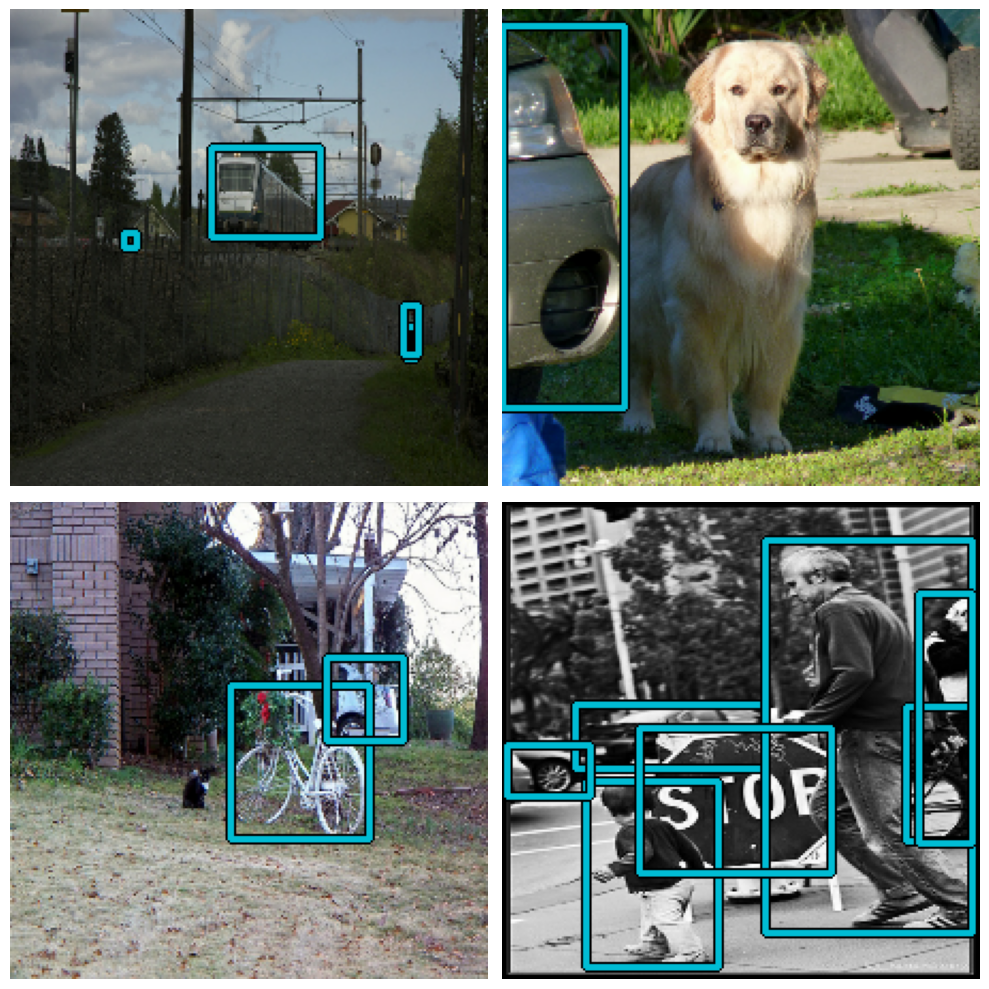

In [12]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )

visualize_dataset(
    train_ds, bounding_box_format=BOUNDING_BOX_FORMAT, value_range=(0, 255), rows=2, cols=2
)

visualize_dataset(
    val_ds, bounding_box_format=BOUNDING_BOX_FORMAT, value_range=(0, 255), rows=2, cols=2
)

In [13]:
def dict_to_tuple(inputs):
    return (
        inputs["images"], 
        (
            inputs["bounding_boxes"]["classes"], 
            inputs["bounding_boxes"]["boxes"],
            inputs["bounding_boxes"]["distances"],
            inputs["masks"],
            inputs["training_modes"]
        )
    )

In [23]:
train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [17]:
model = MobileYOLOv5(num_classes=class_count)
model.compile(
    box_loss_weight=7.5,
    classification_loss_weight=1.0,
    distance_loss_weight=0.5,
    segmentation_loss_weight=1.0,
    optimizer=tf.keras.optimizers.SGD(
        learning_rate=tf.keras.optimizers.schedules.CosineDecayRestarts(
            initial_learning_rate=LEARNING_RATE,
            first_decay_steps=(DECAY_EPOCHS * int(ceil(m-int(m*SPLIT_RATIO)/BATCH_SIZE))),
            alpha=1e-5,
        ),
        momentum=0.937,
        weight_decay=WEIGHT_DECAY,
        global_clipnorm=GLOBAL_CLIPNORM,
        use_ema=True,
        ema_momentum=0.9999
    )
)

In [18]:
train_history = model.fit(train_ds, validation_data=val_ds, batch_size=BATCH_SIZE, epochs=EPOCH)

Epoch 1/5

   9/1188 [..............................] - ETA: 46:31 - loss: 12.3205 - box_loss: 4.7342 - class_loss: 7.5863 - distance_loss: 0.0000e+00 - segmentation_loss: 0.0000e+00

In [ ]:
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    y_pred = bounding_box.to_ragged(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )


visualize_detections(model, dataset=val_ds, bounding_box_format=BOUNDING_BOX_FORMAT)